In [1]:
import os, sys, glob, re
import datetime as dt
import numpy as np
from calendar import monthrange
from matplotlib.dates import date2num, num2date
import h5py
from sklearn import decomposition
import nimfa
from scipy import signal

import matplotlib.pyplot as plt
# from modest_image import imshow
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
%matplotlib inline

In [3]:
save_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_new/'
save_fname = '20150817-20151017_MVBS.h5'

f = h5py.File(os.path.join(save_path,save_fname),"r")
MVBS = np.array(f['MVBS'])

In [4]:
ping_per_day_mvbs = 144

*************************
## Functions for plotting

In [263]:
def plot_comp(V,figsize_input,save_fname='test.png',log_opt=1,cax_all=0,cax=np.nan):
    if log_opt==1:
        V = 10*np.ma.log10(V)
    if np.any(np.isnan(cax)):
        cmean_all = np.mean(V)
        cstd_all = np.std(V)
        cmin_all = max((np.min(V),cmean_all-2*cstd_all))
        cmax_all = min((np.max(V),cmean_all+3*cstd_all))
    else:
        cmin_all = cax[0]
        cmax_all = cax[1]

    fig,ax=plt.subplots(n_comp,1,sharex=True,figsize=figsize_input)
    for c in range(n_comp):
        if log_opt==1:
            vlog = 10*np.ma.log10(V[c,:,:])
        else:
            vlog = V[c,:,:]
        cmean = np.mean(V[c,:,:])
        cstd = np.std(V[c,:,:])
        if cax_all==1:
            cmin = cmin_all
            cmax = cmax_all
        else:
            cmin = max((np.min(V[c,:,:]),cmean-2*cstd))
            cmax = min((np.max(V[c,:,:]),cmean+3*cstd))
        im = ax[c].imshow(V[c,:,:],aspect='auto',vmin=cmin,vmax=cmax)
        divider = make_axes_locatable(ax[c])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im,cax=cax)

        ax[c].set_xticks([x*ping_per_day_mvbs+ping_per_day_mvbs/2 for x in range(3)])
        ax[c].set_xticklabels(['38k','120k','200k'])
        ax[c].tick_params('both', length=0)
    plt.savefig(os.path.join(save_path,save_fname))

In [6]:
def plot_coef(W,yscale=0,save_fname='test.png'):
    plt.figure(figsize=(22,3))
    W[W==0] = sys.float_info.epsilon
    labels = [str(x) for x in range(n_comp)]
    for w, label in zip(W.T, labels):
        plt.plot(range(1,len(w)+1),w, label=label,linewidth=2)
    plt.legend()
    plt.xticks(range(mvbs_long.shape[0]))
    if yscale==1:
        plt.yscale('log')
    plt.xlim([0,mvbs_long.shape[0]])
    plt.savefig(os.path.join(save_path,save_fname))
    plt.show()

In [243]:
def plot_cmp_data_decomp(V,X,plot_day,figsize_input,save_fname='test.png',same_cax_opt=1):
    plot_range_day = 1
    fig,ax = plt.subplots(2,3,figsize=figsize_input)
    for iY in range(2):
        # Get color axis limtis
        v_mtx = V[:,:,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].reshape((-1,1))
        cmean = np.mean(v_mtx)
        cstd = np.std(v_mtx)
        cmax = np.max(v_mtx)

        for iX in range(3):
            if iY==0:
                v = V[iX,:,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)]   # data to be plotted
            else:
                v = X[iX,:,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)]   # data to be plotted

            if same_cax_opt==1:
                im = ax[iY,iX].imshow(v.T,aspect='auto',vmax=cmean+cstd*6,vmin=cmean-cstd*3)#,cmap=e_cmap,norm=e_norm)
            else:
                im = ax[iY,iX].imshow(v.T,aspect='auto')#,cmap=e_cmap,norm=e_norm)
            divider = make_axes_locatable(ax[iY,iX])
            cax = divider.append_axes("right", size="2%", pad=0.1)
            cbar = plt.colorbar(im,cax=cax)
            if iX==0:
                ax[iY,iX].set_title('38 kHz')
            elif iX==1:
                ax[iY,iX].set_title('120 kHz')
            else:
                ax[iY,iX].set_title('200 kHz')
    plt.savefig(os.path.join(save_path,save_fname))

In [8]:
def plot_original_echogram(plot_start_day,plot_range_day):
#     plot_start_day = 42
#     plot_range_day = 10
    fig,ax = plt.subplots(3,1,figsize=(15,6))
    ax[0].imshow(MVBS[0,1:-2,ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',vmin=-80,vmax=-30)#,cmap=e_cmap,norm=e_norm)
    ax[1].imshow(MVBS[1,1:-2,ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',vmin=-80,vmax=-30)#,cmap=e_cmap,norm=e_norm)
    ax[2].imshow(MVBS[2,1:-2,ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',vmin=-80,vmax=-30)#,cmap=e_cmap,norm=e_norm)
    ax[2].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
    ax[2].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
    ax[2].set_xlabel('Day',fontsize=14)
    plt.show()

In [9]:
def separate_transform(D,ori_data,log_opt=1):
    D_long = D.reshape((D.shape[0],-1,ori_data.shape[1])).swapaxes(1,2)
    D_sep = D_long.reshape((D_long.shape[0],D_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
    if log_opt==1:
        D_plot = 10*np.log10(D_sep.transpose((0,2,1,3))).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    else:
        D_plot = D_sep.transpose((0,2,1,3)).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    return D_sep,D_plot

******************************************
## NIMFA decomposition

In [10]:
mvbs = 10**(MVBS[:,1:-2,:-3*ping_per_day_mvbs]/10)
# mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [11]:
MVBS_copy = np.copy(MVBS[:,1:-2,:-3*ping_per_day_mvbs])
# MVBS_copy = np.copy(MVBS[:,1:-2,:])
MVBS_3freq = np.array([MVBS_copy[ff,:,:].T.reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1])) for ff in range(3)])
MVBS_long = MVBS_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1]*3))

In [54]:
n_comp = 5

nmf_lin = nimfa.Nmf(mvbs_long,rank=n_comp,update='divergence',objective='div',n_run=10)
nmf_lin_fit = nmf_lin()
W_nmf_lin = np.array(nmf_lin_fit.basis())
H_nmf_lin = np.array(nmf_lin_fit.coef())
V_nmf_lin = H_nmf_lin.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_nmf_lin = np.dot(W_nmf_lin,H_nmf_lin)
D_nmf_lin_sep,D_nmf_lin_plot = separate_transform(D_nmf_lin,mvbs,log_opt=0)

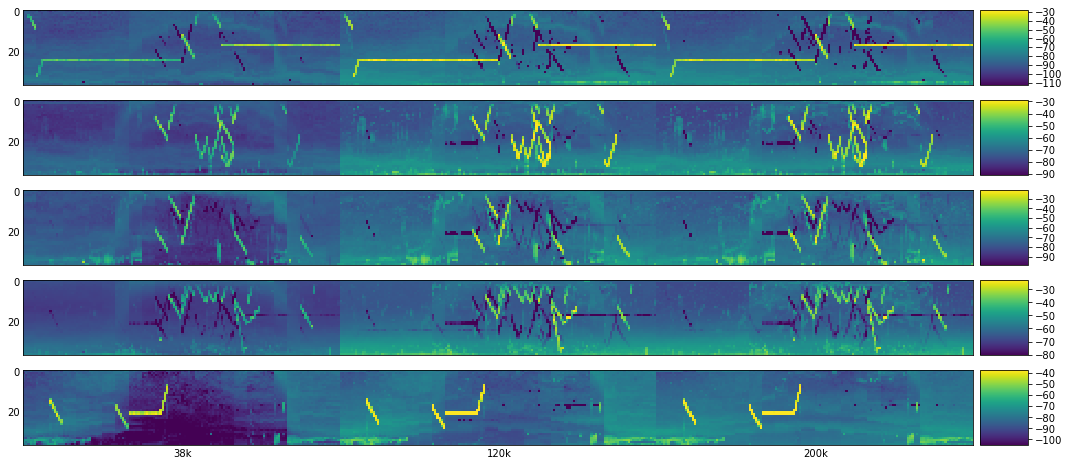

In [55]:
plot_comp(V_nmf_lin,figsize_input=(18,8),save_fname='59days_nimfa_nmf_lin_5comp.png',log_opt=1)

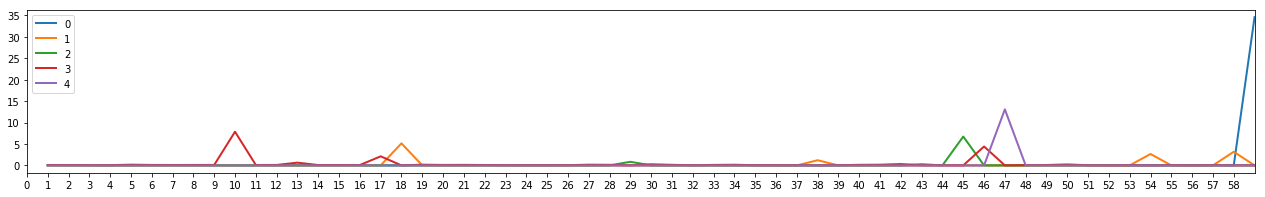

In [56]:
plot_coef(W_nmf_lin,yscale=0,save_fname='test.png')

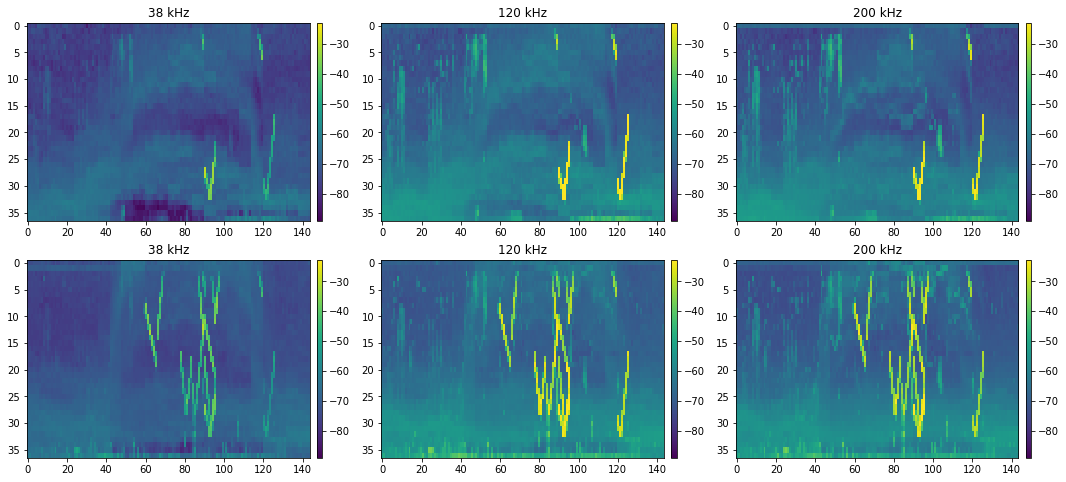

In [66]:
plot_day = 58
plot_cmp_data_decomp(MVBS,10*np.log10(D_nmf_lin_plot),plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

In [98]:
n_comp = 5

nmf_log = nimfa.Nmf(MVBS_long-MVBS_long.min(),rank=n_comp,update='divergence',objective='div',max_iter=1000,n_run=10)
nmf_log_fit = nmf_log()
W_nmf_log = np.array(nmf_log_fit.basis())
H_nmf_log = np.array(nmf_log_fit.coef())
V_nmf_log = H_nmf_log.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [100]:
D_nmf_log = np.dot(W_nmf_log,H_nmf_log)
D_nmf_log_sep,D_nmf_log_plot = separate_transform(D_nmf_log,mvbs,log_opt=0)

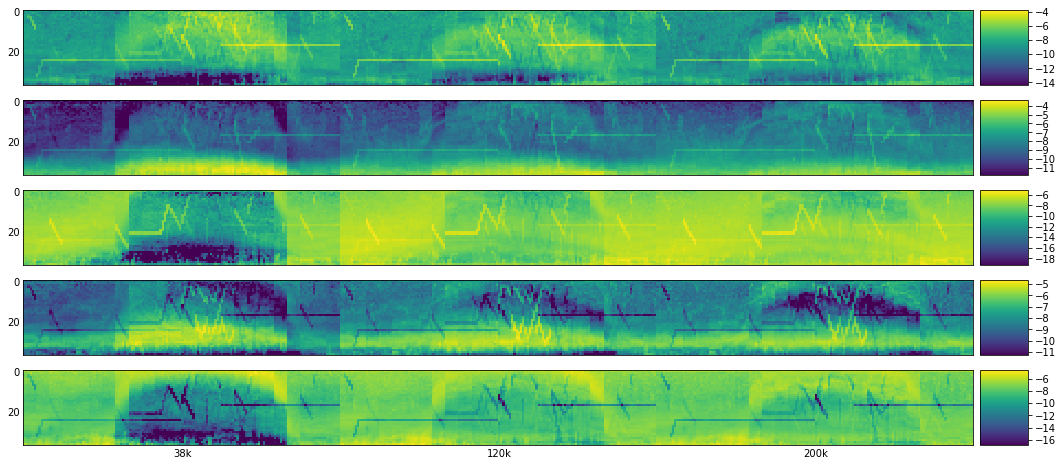

In [101]:
plot_comp(V_nmf_log,figsize_input=(18,8),save_fname='59days_nimfa_nmf_log_5comp.png',log_opt=1)

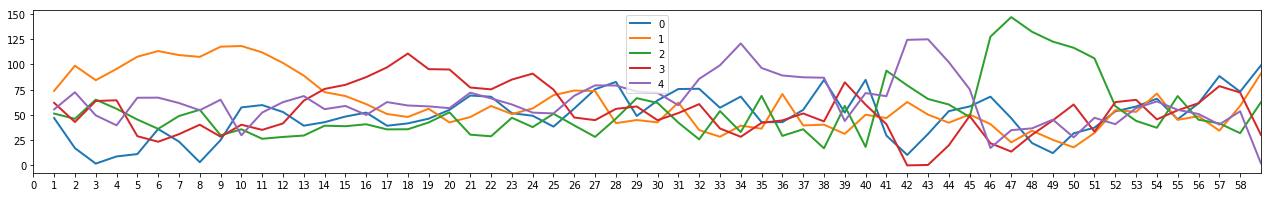

In [103]:
plot_coef(W_nmf_log,yscale=0,save_fname='test.png')

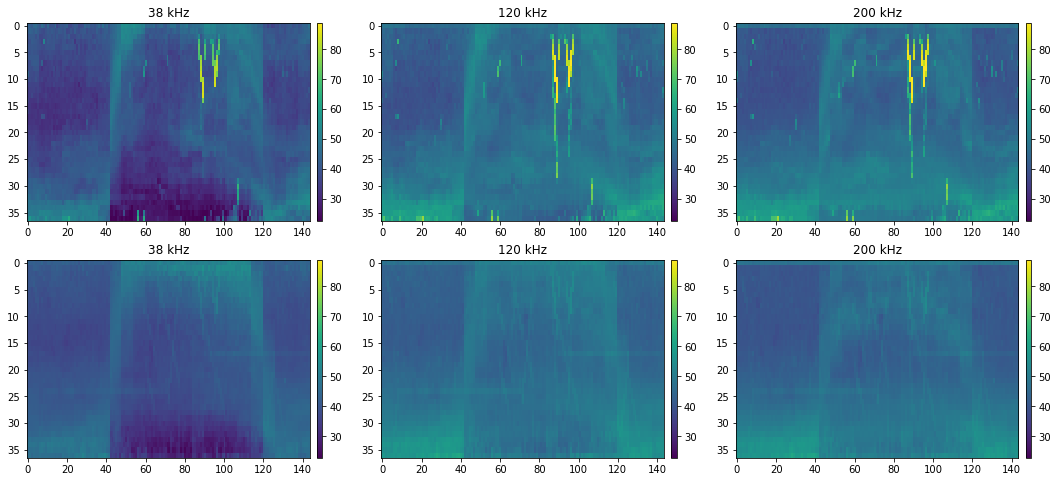

In [111]:
plot_day = 38
plot_cmp_data_decomp(MVBS_copy-MVBS_copy.min(),D_nmf_log_plot,plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

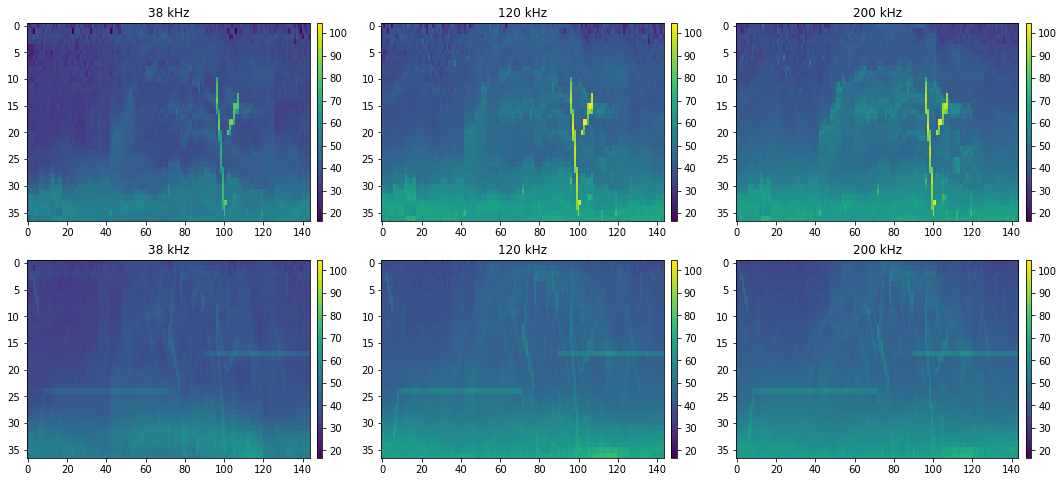

In [112]:
plot_day = 10
plot_cmp_data_decomp(MVBS_copy-MVBS_copy.min(),D_nmf_log_plot,plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

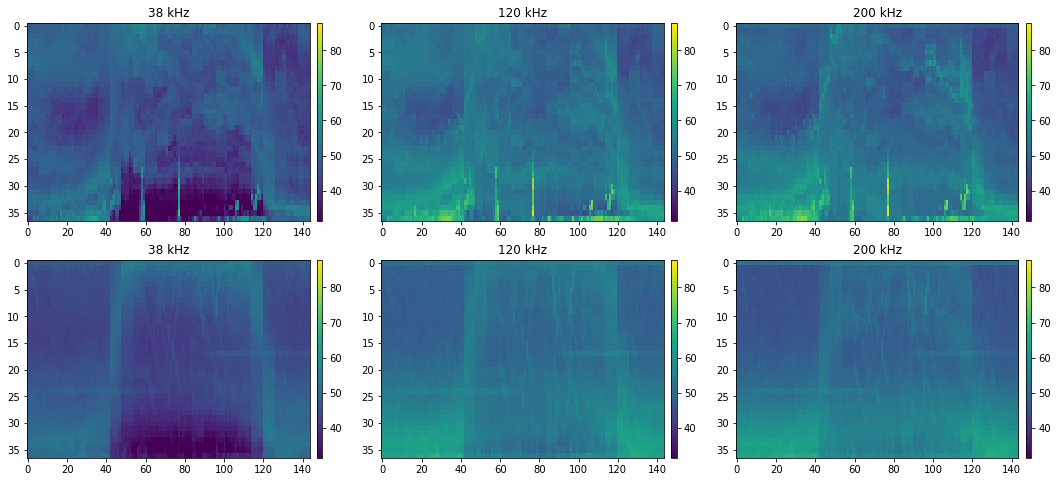

In [113]:
plot_day = 28
plot_cmp_data_decomp(MVBS_copy-MVBS_copy.min(),D_nmf_log_plot,plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

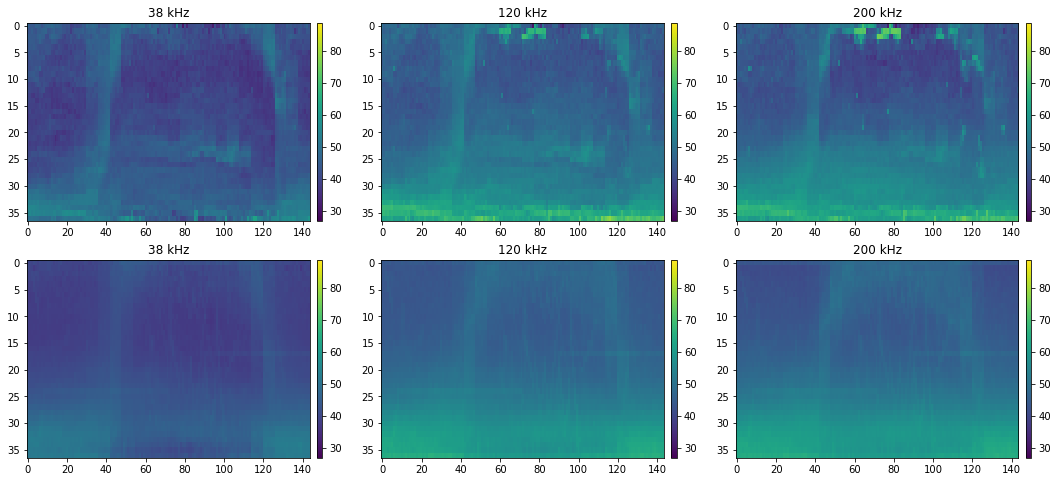

In [134]:
plot_day = 1
plot_cmp_data_decomp(MVBS_copy-MVBS_copy.min(),D_nmf_log_plot,plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

**************************************
## Thoughts...
The log-domain NMF using NIMFA seems to separate out the profiler echoes better and the reconstructed echograms are much more _low-ranked_. What about reconstruct the whole thing in log-domain, transform it back to the linear domain, and do linear-domain NMF on it?

In [107]:
D_nmf_log_plot.shape

(3, 37, 8496)

In [109]:
MVBS_copy.shape

(3, 37, 8496)

Get `MVBS_copy` into the same format as `D_nmf_log_sep` for plotting.

In [175]:
MVBS_sep,_ = separate_transform(MVBS_long,mvbs,log_opt=0)

Below I am comparing the original and reconstructed data using 1st level log-domain decomposition. Visual comparision is done over multiple days so that it is easy to spot the patterns.

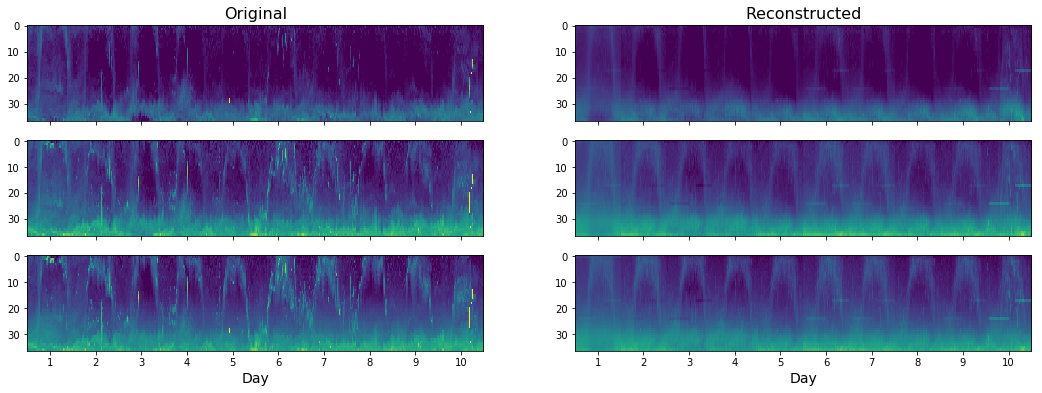

In [240]:
plot_start_day = 1
plot_range_day = 10
fig,ax = plt.subplots(3,2,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(2):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

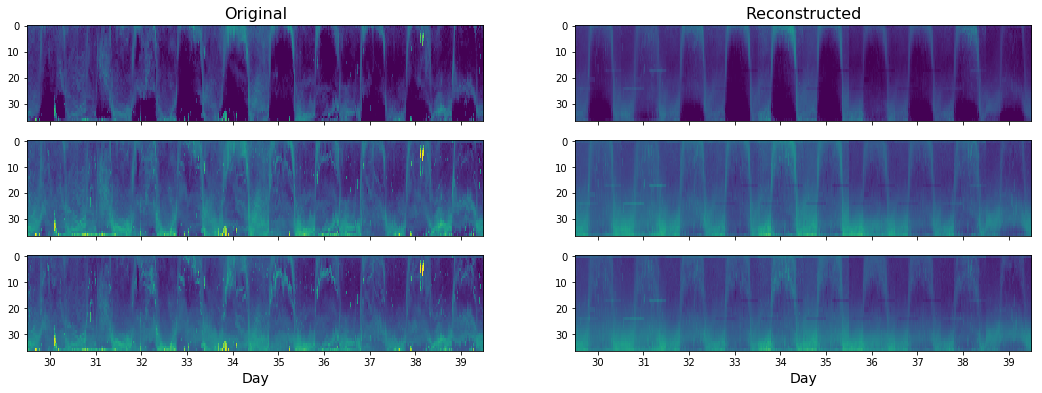

In [241]:
plot_start_day = 30
plot_range_day = 10
fig,ax = plt.subplots(3,2,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(2):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

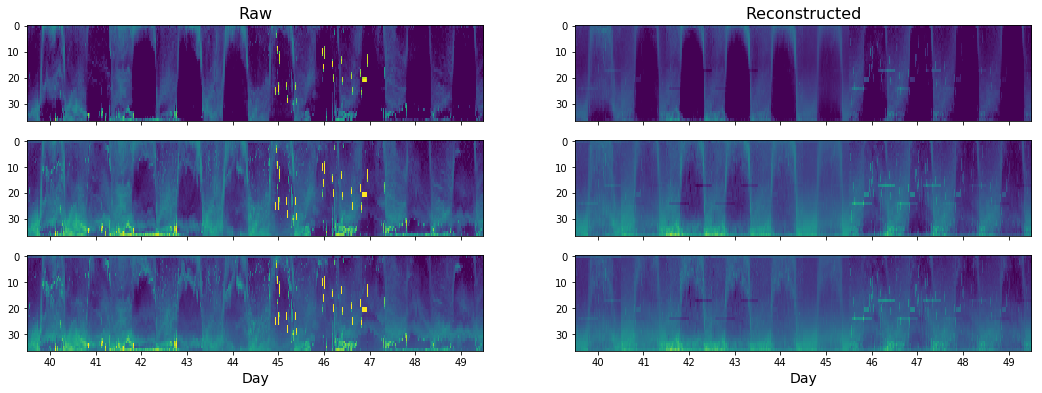

In [171]:
plot_start_day = 40
plot_range_day = 10
fig,ax = plt.subplots(3,2,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(2):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Raw',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

The visual pattern seems consistent for the original and reconstructed data when viewing the matrix used for decomposition directly. Notice that the bright spots in the original data are profiler echoes and they are much more reduced in the reconstructed data.

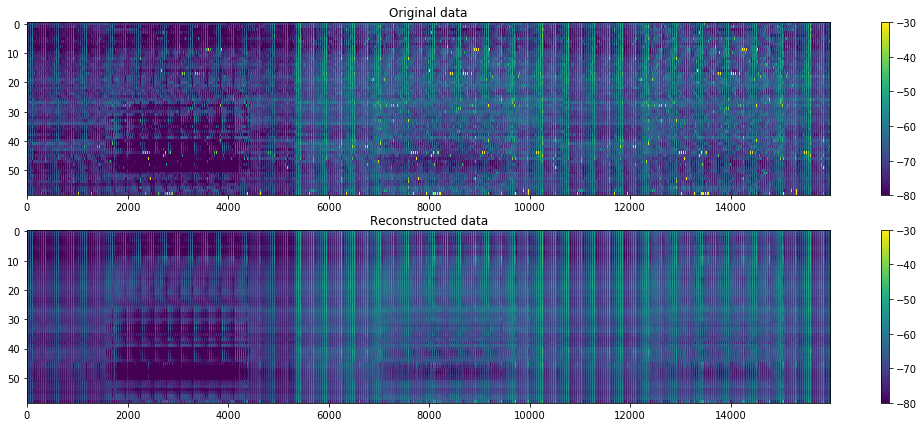

In [195]:
fig = plt.figure(figsize=(18,7))
fig.add_subplot(2,1,1)
plt.imshow(MVBS_long,aspect='auto',vmin=-80,vmax=-30)
plt.title('Original data')
plt.colorbar()
fig.add_subplot(2,1,2)
plt.imshow(D_nmf_log+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
plt.title('Reconstructed data')
plt.colorbar()

************************************************
## 2nd level decomposition in linear domain

Now do NMF in the linear domain using the reconstructed data after 1st level decomposition. I first transformed the reconstructed data from the log to the linear domain, and compensate for the factor (`MVBS_copy.min()`) added to make the log-domain `MVBS` all _positive_ in the 1st level decomposition. And then I ran NMF using the same parameters as the 1st level decomposition, but now doing everything in the linear domain.

In [273]:
D_nmf_log_2lin = 10**((D_nmf_log+MVBS_copy.min())/10)

### Number of component = 5

In [211]:
n_comp = 5

nmf_recons_lin = nimfa.Nmf(D_nmf_log_2lin,rank=n_comp,update='divergence',objective='div',max_iter=1000,n_run=10)
nmf_recons_lin_fit = nmf_recons_lin()
W_nmf_recons_lin = np.array(nmf_recons_lin_fit.basis())
H_nmf_recons_lin = np.array(nmf_recons_lin_fit.coef())
V_nmf_recons_lin = H_nmf_recons_lin.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [212]:
D_nmf_recons_lin = np.dot(W_nmf_recons_lin,H_nmf_recons_lin)
D_nmf_recons_lin_sep,D_nmf_recons_lin_plot = separate_transform(D_nmf_recons_lin,mvbs,log_opt=0)

It seems like that the decomposition is cleaner without the profiler echoes, as shown below, although each of the patterns looks very smeared.

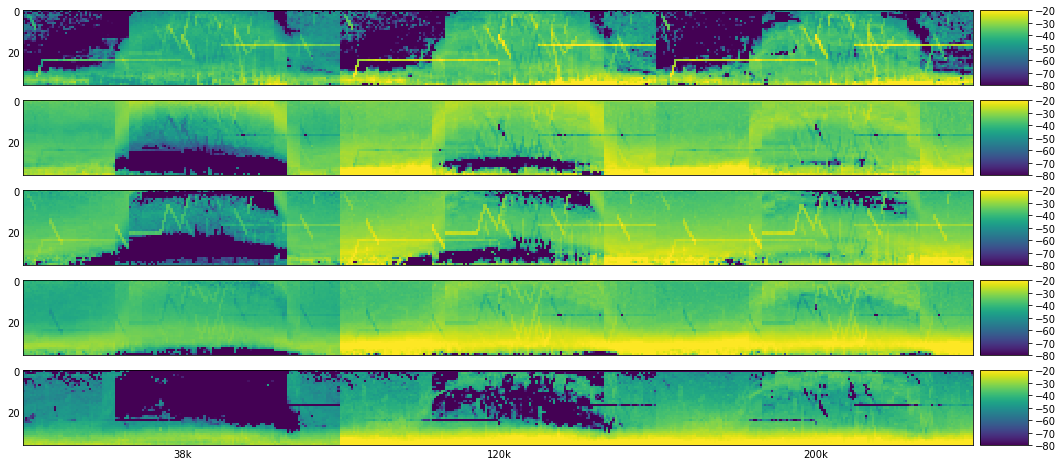

In [265]:
plot_comp(V_nmf_recons_lin,figsize_input=(18,8),save_fname='59days_nimfa_nmf_recons_lin_5comp.png',\
          log_opt=1,cax_all=1,cax=(-80,-20))

The activation of compmonent #3, #4 seems pretty obvious, but others were not very strong. Component #1, which seems to correspond with the DVM pattern only peaks at Day 27, 34, 42-43, and doesn't maintain a high level throughout the period, like one-level log-domain NMF shows before. Not sure why this is the case. Perhaps `n_comp=5` is too large?

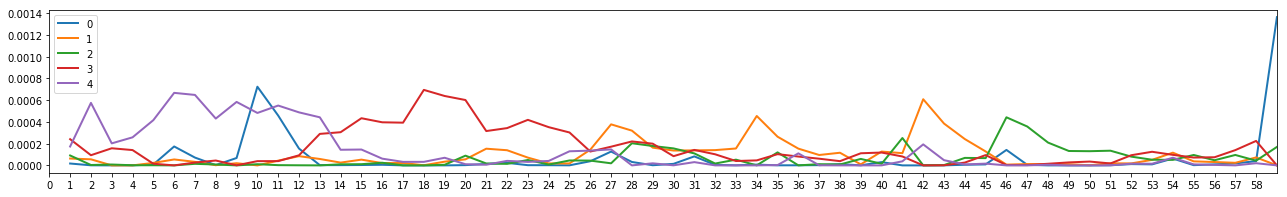

In [214]:
plot_coef(W_nmf_recons_lin,yscale=0,save_fname='test.png')

Reconstructionn seems ok but not perfect between reconstructed and reconstructedx2 results.

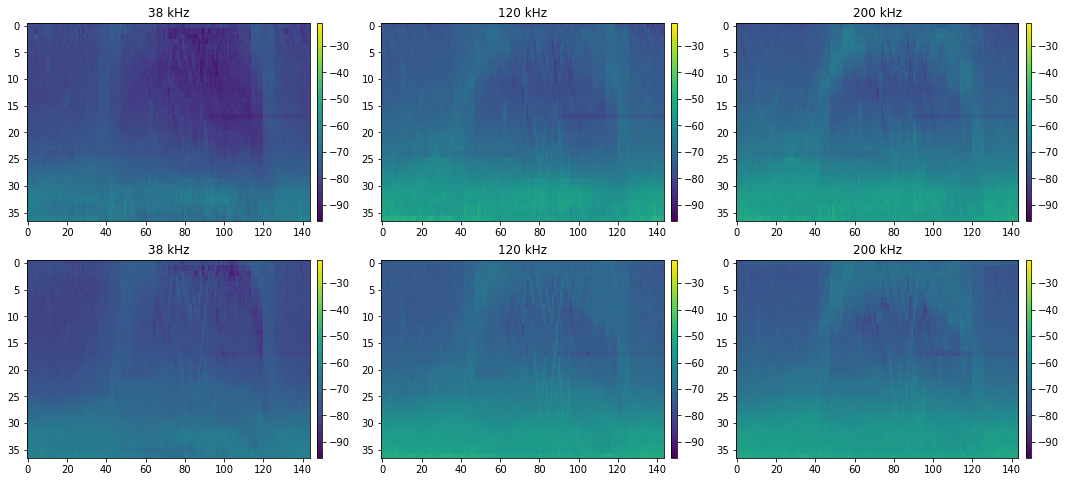

In [230]:
plot_day = 3
plot_cmp_data_decomp(D_nmf_log_plot+MVBS_copy.min(),10*np.log10(D_nmf_recons_lin_plot),plot_day,\
                     figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

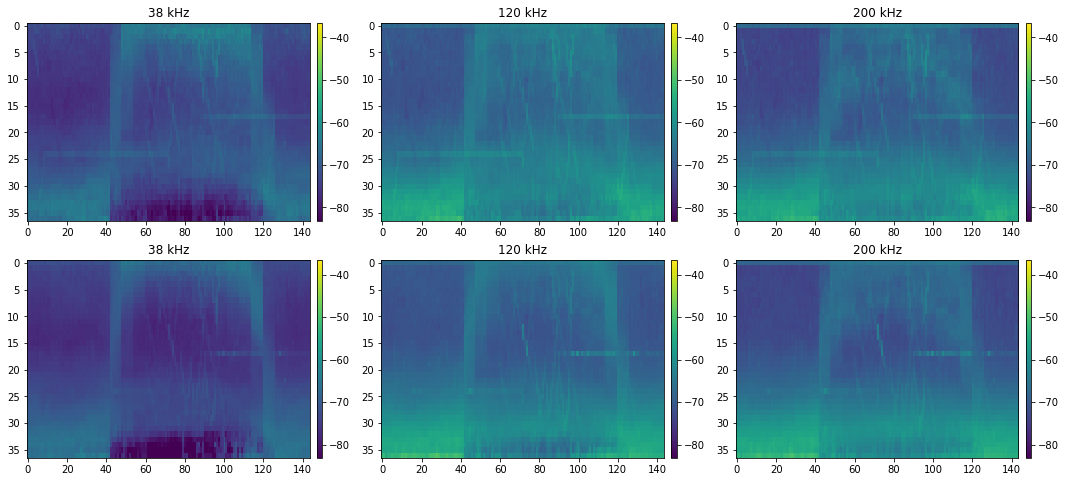

In [232]:
plot_day = 40
plot_cmp_data_decomp(D_nmf_log_plot+MVBS_copy.min(),10*np.log10(D_nmf_recons_lin_plot),plot_day,\
                     figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

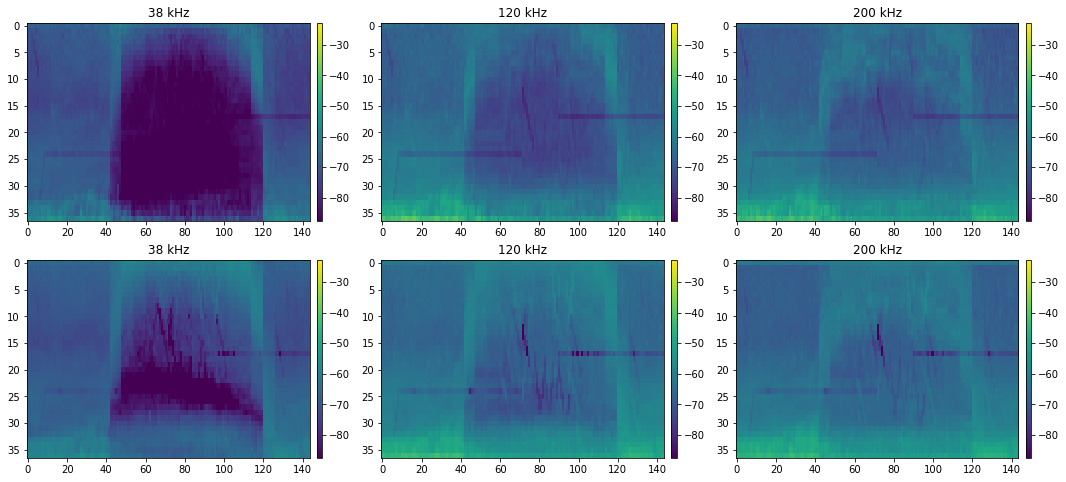

In [266]:
plot_day = 42
plot_cmp_data_decomp(D_nmf_log_plot+MVBS_copy.min(),10*np.log10(D_nmf_recons_lin_plot),plot_day,\
                     figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

And for larger visual patterns, `Reconstructed x2` seems to capture most of the patterns shown in `Reconstructed`, although from `Original` to `Reconstructed` there is a lot of los... which is expected.

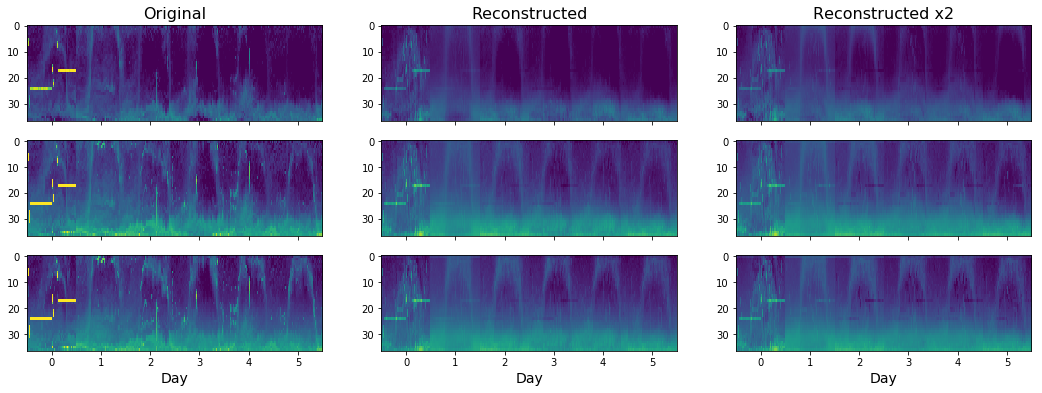

In [267]:
plot_start_day = 0
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

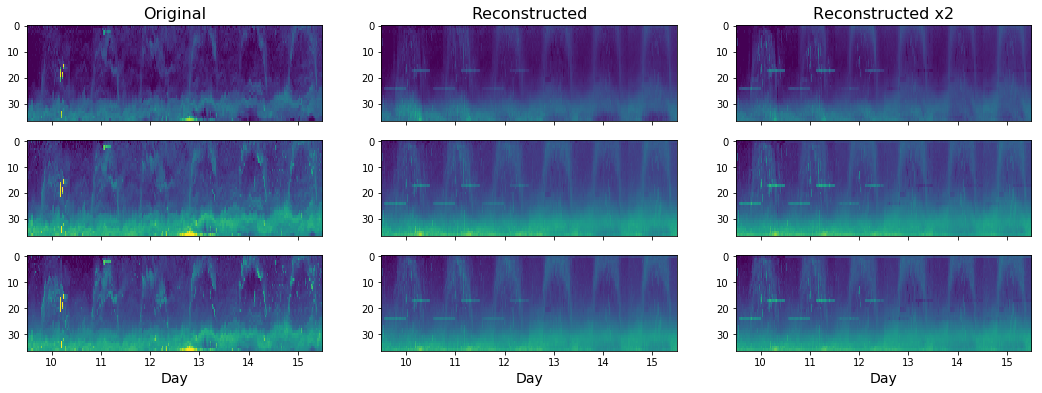

In [268]:
plot_start_day = 10
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

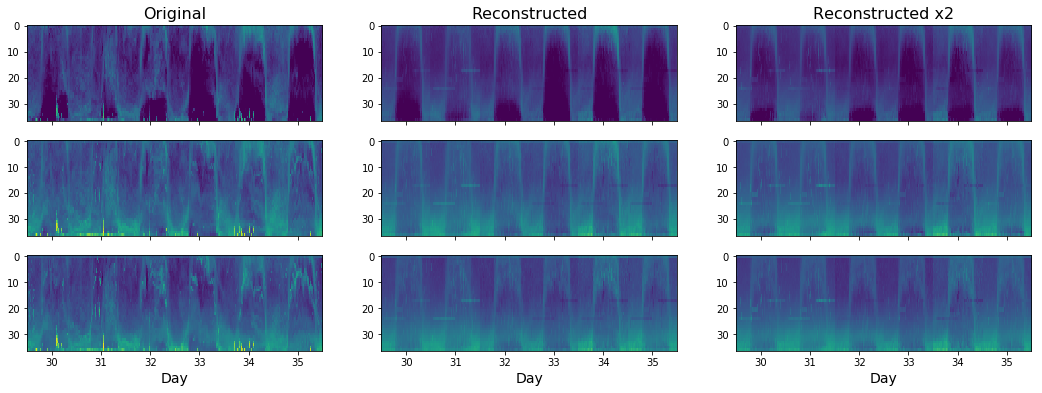

In [269]:
plot_start_day = 30
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

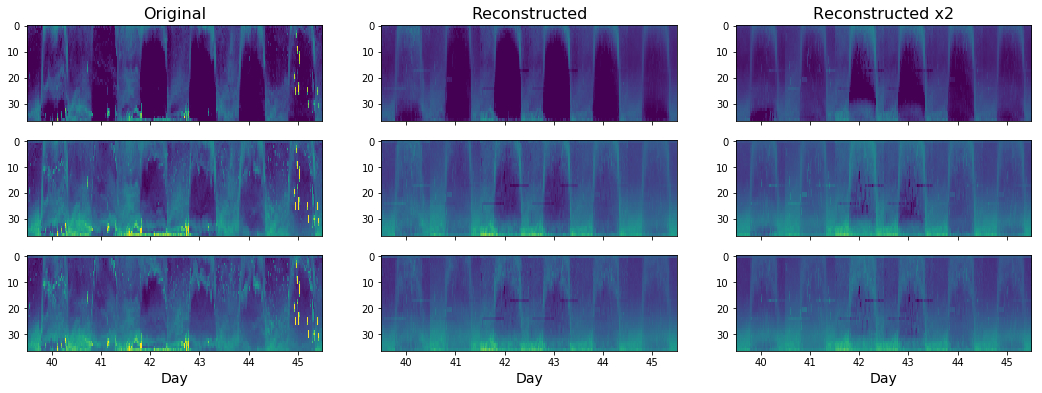

In [271]:
plot_start_day = 40
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

### Number of component = 3

Now let's try to the 2nd level decomposition using only 3 components...

In [274]:
n_comp = 3

nmf_recons_lin_3 = nimfa.Nmf(D_nmf_log_2lin,rank=n_comp,update='divergence',objective='div',max_iter=1000,n_run=10)
nmf_recons_lin_3_fit = nmf_recons_lin_3()
W_nmf_recons_lin_3 = np.array(nmf_recons_lin_3_fit.basis())
H_nmf_recons_lin_3 = np.array(nmf_recons_lin_3_fit.coef())
V_nmf_recons_lin_3 = H_nmf_recons_lin_3.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [275]:
D_nmf_recons_lin_3 = np.dot(W_nmf_recons_lin_3,H_nmf_recons_lin_3)
D_nmf_recons_lin_3_sep,D_nmf_recons_lin_3_plot = separate_transform(D_nmf_recons_lin_3,mvbs,log_opt=0)

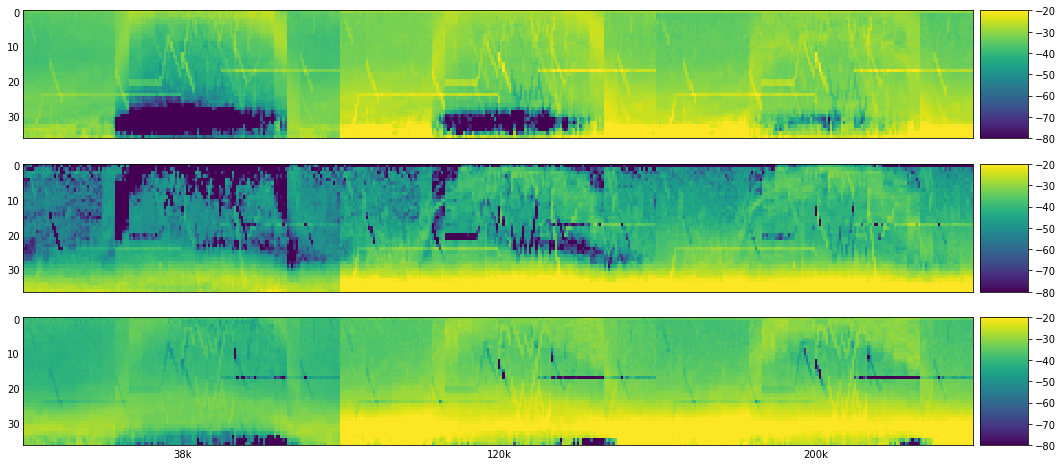

In [276]:
plot_comp(V_nmf_recons_lin_3,figsize_input=(18,8),save_fname='59days_nimfa_nmf_recons_lin_3comp.png',\
          log_opt=1,cax_all=1,cax=(-80,-20))

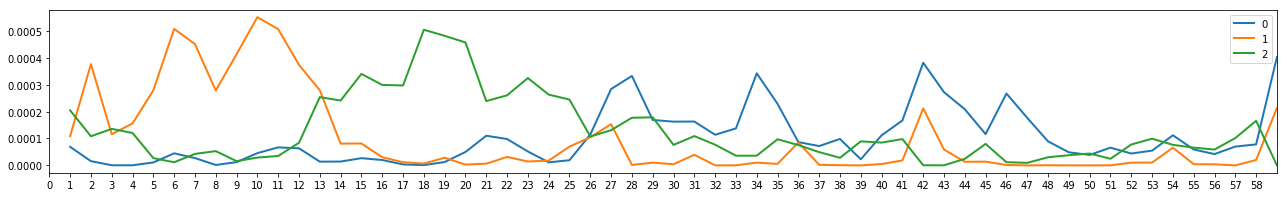

In [277]:
plot_coef(W_nmf_recons_lin_3,yscale=0,save_fname='test.png')

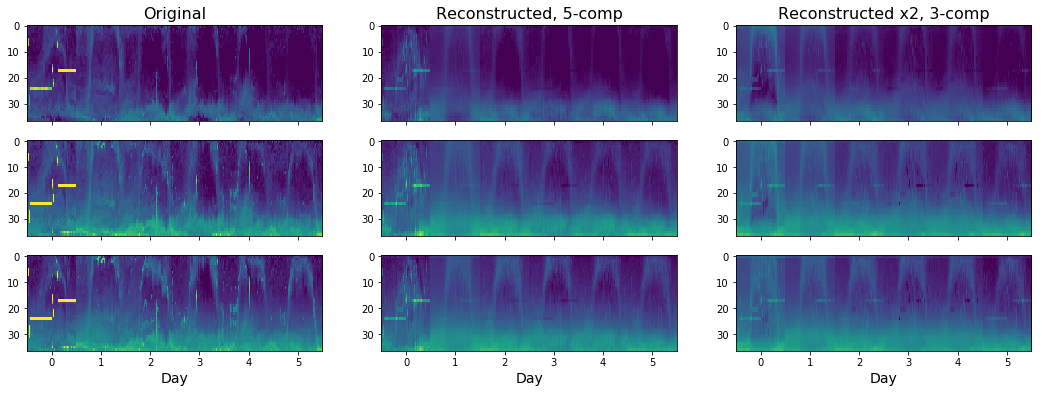

In [278]:
plot_start_day = 0
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_3_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed, 5-comp',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2, 3-comp',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

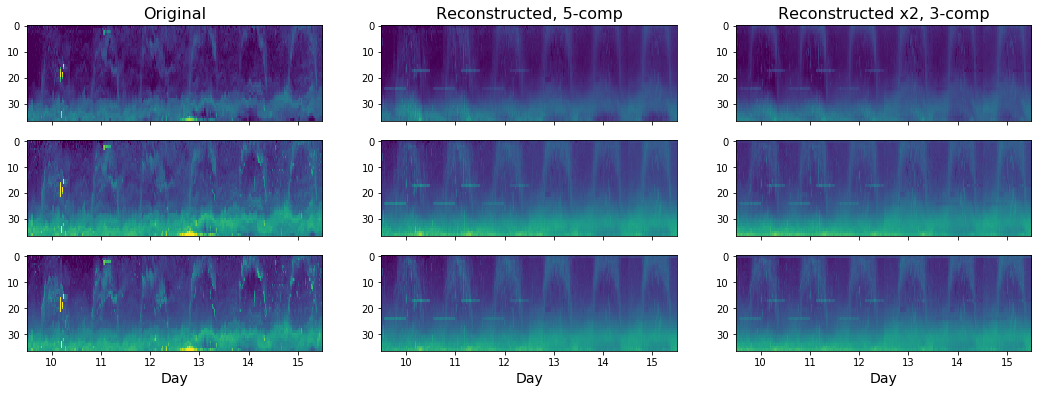

In [279]:
plot_start_day = 10
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_3_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed, 5-comp',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2, 3-comp',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

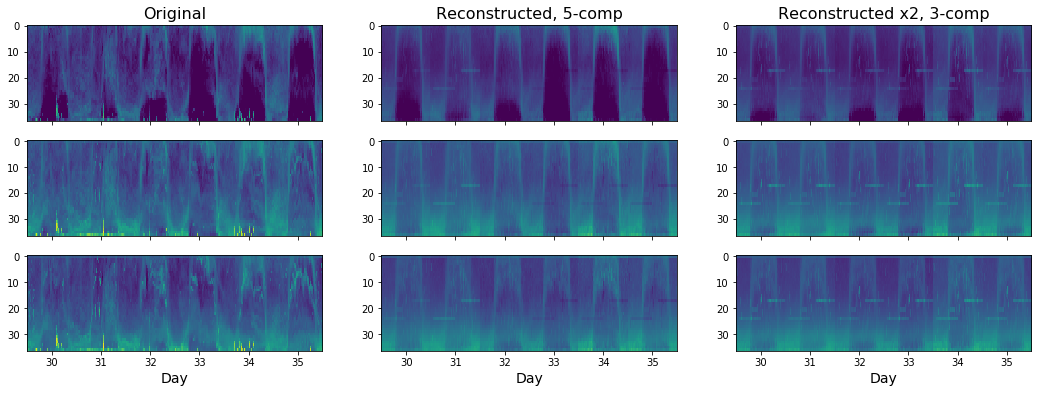

In [280]:
plot_start_day = 30
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_3_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed, 5-comp',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2, 3-comp',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

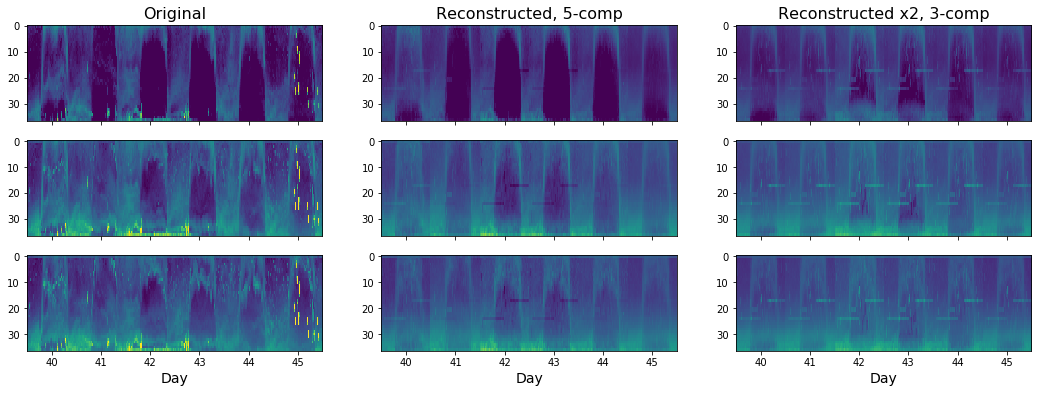

In [281]:
plot_start_day = 40
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_3_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed, 5-comp',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2, 3-comp',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

### Number of component = 4

Seems like `n_comp=3` is too small and in Day 40-45, the emtpy water column during the day time was not captured. And in general the remaning profiler echoes from the 1st level log-domain decomposition bleed into the 2nd level reconstruction. Now try `n_comp=4`.

In [282]:
n_comp = 4

nmf_recons_lin_4 = nimfa.Nmf(D_nmf_log_2lin,rank=n_comp,update='divergence',objective='div',max_iter=1000,n_run=10)
nmf_recons_lin_4_fit = nmf_recons_lin_4()
W_nmf_recons_lin_4 = np.array(nmf_recons_lin_4_fit.basis())
H_nmf_recons_lin_4 = np.array(nmf_recons_lin_4_fit.coef())
V_nmf_recons_lin_4 = H_nmf_recons_lin_4.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [283]:
D_nmf_recons_lin_4 = np.dot(W_nmf_recons_lin_4,H_nmf_recons_lin_4)
D_nmf_recons_lin_4_sep,D_nmf_recons_lin_4_plot = separate_transform(D_nmf_recons_lin_4,mvbs,log_opt=0)

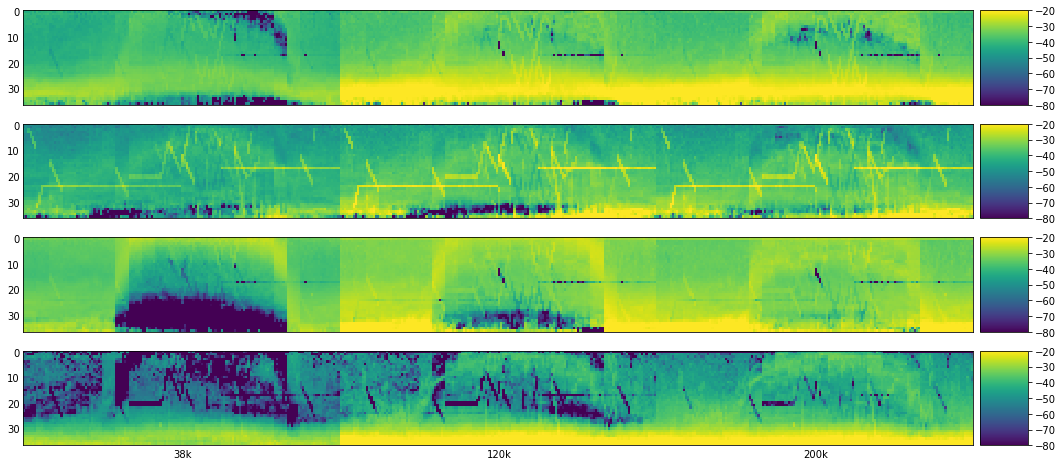

In [284]:
plot_comp(V_nmf_recons_lin_4,figsize_input=(18,8),save_fname='59days_nimfa_nmf_recons_lin_4comp.png',\
          log_opt=1,cax_all=1,cax=(-80,-20))

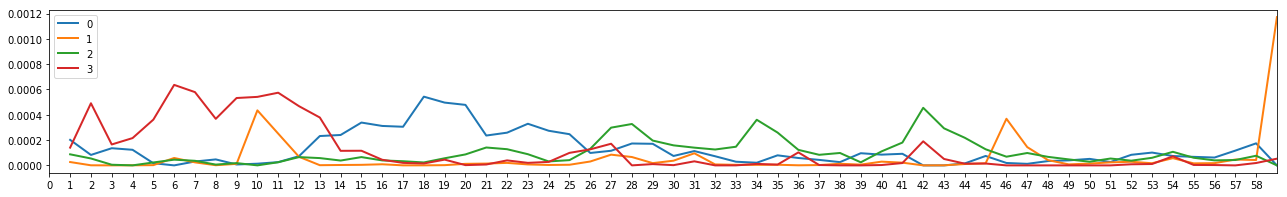

In [290]:
plot_coef(W_nmf_recons_lin_4,yscale=0,save_fname='test.png')

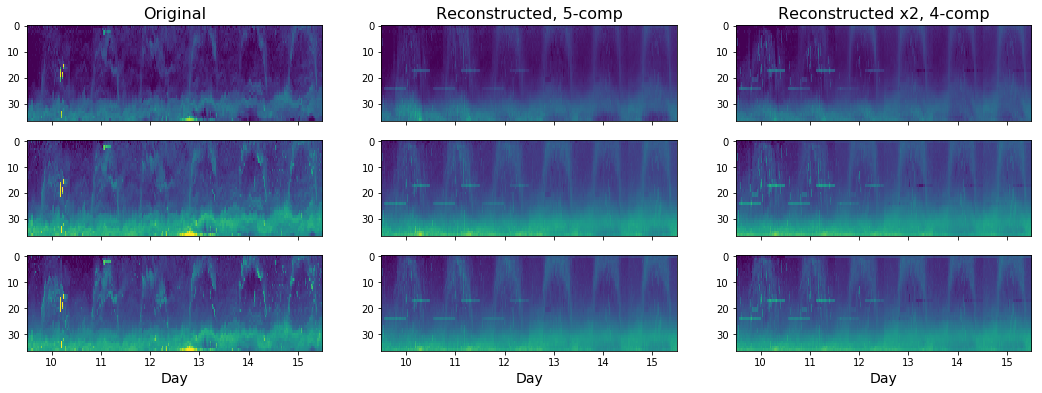

In [291]:
plot_start_day = 10
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_4_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed, 5-comp',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2, 4-comp',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

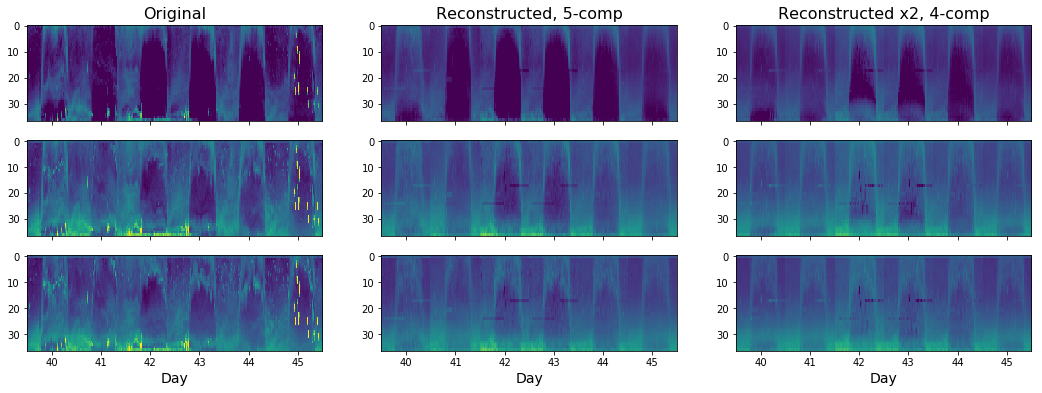

In [292]:
plot_start_day = 40
plot_range_day = 6
fig,ax = plt.subplots(3,3,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(3):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        elif iX==1:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(10*np.log10(D_nmf_recons_lin_4_plot[iY,:,idx]).T,aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Original',fontsize=16)
            elif iX==1:
                ax[iY,iX].set_title('Reconstructed, 5-comp',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed x2, 4-comp',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()